# Introduction

This work is focused on applying my skills in feature engineering, machine learning models for structure data and data science methodology, so I will work as I were as **data scientist** for a insurance company.

This insurance company sells life insurance to travelers who use ships or cruises, therefore, they want to increase their incomes setting the best tariffs to their clients.

For this experiment I will use Titanic disaster (https://www.kaggle.com/c/titanic/overview).

Additionally, I will use like guide to feature engineering the work of **Manav Sehgal** (https://www.kaggle.com/startupsci/titanic-data-science-solutions).

More information:

https://machinelearningmastery.com/parametric-statistical-significance-tests-in-python/

https://towardsdatascience.com/skewed-data-a-problem-to-your-statistical-model-9a6b5bb74e37

# Data science methodology

## 1. Business understanding:
In this stage I need to respond the next question: **what is the problem that we are trying to solve?** In this case, the problem is defined with another question: **how to set better tariffs to our clients in order to increase our incomes?**.

* **Define goals**: set better tariffs to our clients.

* **Define the objetives**: understand person survival in a ship disaster.

## 2. Analytic approach:
In this stage I will focus on determining what clients have more probability to survive, so those clients will keep their tariffs, otherwise will be charge more. In other words, clients with high risk of death should have to pay more.

With this information, **I will recomend to handle this problem using a classification model**.

## 3. Data requirements:
In this stage I will determine what data I will use to solve the problem. To keep this work easy, I will use **titanic disaster data**, because this data has many features to determine if a person survive.
Additionally, I will use structure data.

## 4. Data collection:
In this stage I need to determine what are the extraction methods and what are the data sources.

I get the data from Kaggle competition, and this is stored in csv format.

## 5. Data understanding
In this stage I will use descriptive statistics and visualization techniques to understand the data, and to know whether this data is useful or not.

Features:
* **Pclass (categorical)**: ticket class.
* **Name (string)**: name of passenger.
* **Sex (categorical)**: sex.
* **Age (numerical - discrete)**: age in years.
* **SibSp (numerical - discrete)**: number of siblings / spouses aboard.
* **Parch (numerical - discrete)**: number of parents / children aboard the Titanic.
* **Ticket (string)**: ticket number.
* **Fare (numerical - continuos)**: passenger fare.
* **Cabin (string)**: cabin number.
* **Embarked (categorical)**: port of Embarkation.

In [ ]:
# Tools for data exploration
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
import math
import scipy.stats as stats

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
from google.colab import files
uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 68 bytes


In [ ]:
!kaggle competitions download -c titanic

  0% 0.00/3.18k [00:00<?, ?B/s]
100% 3.18k/3.18k [00:00<00:00, 6.56MB/s]
  0% 0.00/28.0k [00:00<?, ?B/s]
100% 28.0k/28.0k [00:00<00:00, 8.78MB/s]
  0% 0.00/59.8k [00:00<?, ?B/s]
100% 59.8k/59.8k [00:00<00:00, 57.6MB/s]


In [ ]:
dsTrain = pd.read_csv('/content/train.csv')

In [ ]:
dsTest = pd.read_csv('/content/test.csv')

###5.1. Exploratory data analysis for training data

In [ ]:
dsTrain.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


The training dataset has 891 observations. This is a very small number, but for this work is ok. For real cases, I will need more.


In [ ]:
dsTrain.shape

(891, 12)

This dataset has many null observations, fortunately most variables are complete.

In [ ]:
dsTrain.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


#### 5.1.1. Exploring numerical variables

In [ ]:
dsTrain[['PassengerId','Age', 'Fare', 'SibSp', 'Parch']].describe()

,PassengerId,Age,Fare,SibSp,Parch
count,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,29.699118,32.204208,0.523008,0.381594
std,257.353842,14.526497,49.693429,1.102743,0.806057
min,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,20.125000,7.910400,0.000000,0.000000
50%,446.000000,28.000000,14.454200,0.000000,0.000000
75%,668.500000,38.000000,31.000000,1.000000,0.000000
max,891.000000,80.000000,512.329200,8.000000,6.000000


Evaluating whether there is an association between Age and Survived variable using **difference of two means**.

/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


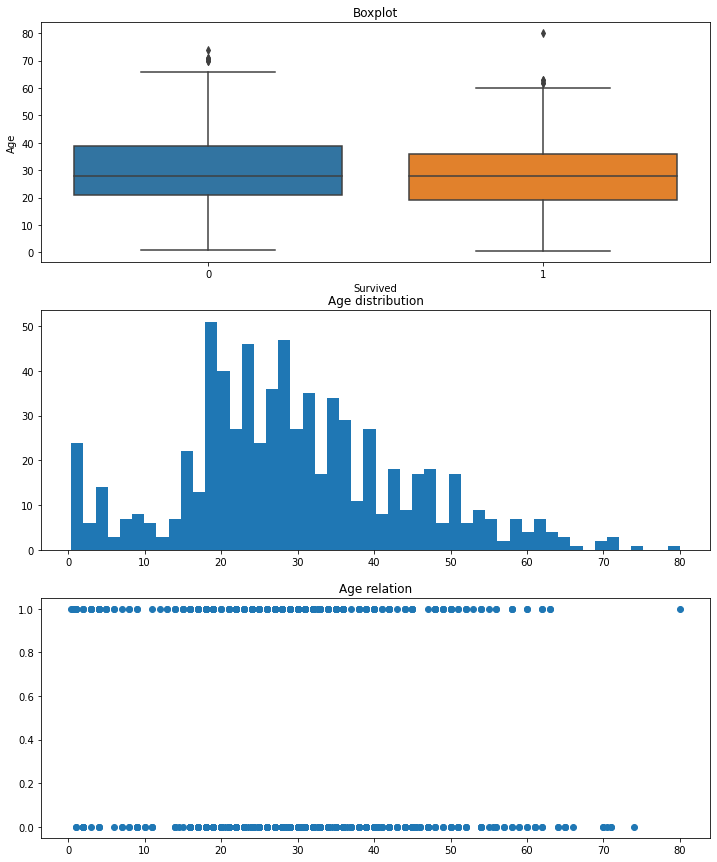

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize = (12, 15))

sns.boxplot(x = dsTrain['Survived'], y = dsTrain['Age'], ax = ax1)
ax1.set_title('Boxplot')

ax2.hist(dsTrain['Age'], bins = 50)
ax2.set_title('Age distribution')

ax3.scatter(dsTrain['Age'], dsTrain['Survived'])
ax3.set_title('Age relation')

plt.show()

In [ ]:
dsTrain[['Age', 'Survived']].groupby(['Survived']).agg(['mean', 'count', 'std']).reset_index()

Survived        Age                 
                 mean count        std
0        0  30.626179   424  14.172110
1        1  28.343690   290  14.950952

In [ ]:
# Calculating p-value
alpha = 0.05 #Significance level
nSurvived = dsTrain[dsTrain['Survived'] == 1]['Age'].count()
nNoSurvived = dsTrain[dsTrain['Survived'] == 0]['Age'].count()
varSurvived = dsTrain[dsTrain['Survived'] == 1]['Age'].var()
varNoSurvived = dsTrain[dsTrain['Survived'] == 0]['Age'].var()
meanSurvived = dsTrain[dsTrain['Survived'] == 1]['Age'].mean()
meanNoSurvived = dsTrain[dsTrain['Survived'] == 0]['Age'].mean()
diffMean = meanSurvived - meanNoSurvived
se = np.sqrt((varSurvived / nSurvived) + (varNoSurvived / nNoSurvived))

print('Null hypothesis:',  0)
print('Alternative hypothesis:',  diffMean)
print('Standard error:', se)

tTest = np.abs((diffMean - 0) / se) #remove negative result
print('t-Test:', tTest)

df = np.min([nSurvived - 1, nNoSurvived - 1])
print('Degrees of freedom:', df)

p_value = (1 - stats.t.cdf(tTest, df = df)) * 2 #Calculating two-sided hypothesis
print('p-value:', p_value)

if p_value < alpha:
  print('Conclusion:', 'There is enough evidence to reject null hypothesis, and I can say that there is a difference between survived mean and no survived. So, Age variable and Survived variable are associated.')
else:
  print('Conclusion:', 'There is not enough evidence to reject null hypothesis, and I can say that there is no a difference between survived mean and no survived. So, Age variable and Survived variable are not associated.')

# Calculating confidence interval at 95% of confidence
tTest = stats.t.ppf(1 - alpha / 2, df = df)
ci = (diffMean - tTest*se, diffMean + tTest*se)
print('t-Test at 95%', tTest)
print('Confidence interval at 95% of confidence:', ci)

del alpha, nSurvived, nNoSurvived, varSurvived, varNoSurvived, diffMean, se, tTest, df, p_value, ci

Null hypothesis: 0
Alternative hypothesis: -2.282489590110604
Standard error: 1.1155698956769122
t-Test: 2.046030104393971
Degrees of freedom: 289
p-value: 0.04165829212849381
Conclusion: There is enough evidence to reject null hypothesis, and I can say that there is a difference between survived mean and no survived. So, Age variable and Survived variable are associated.
t-Test at 95% 1.9682064355041717
Confidence interval at 95% of confidence: (-4.47816143803662, -0.08681774218458793)


Evaluating whether there is an association between Fare and Survived variable using **difference of two means**.

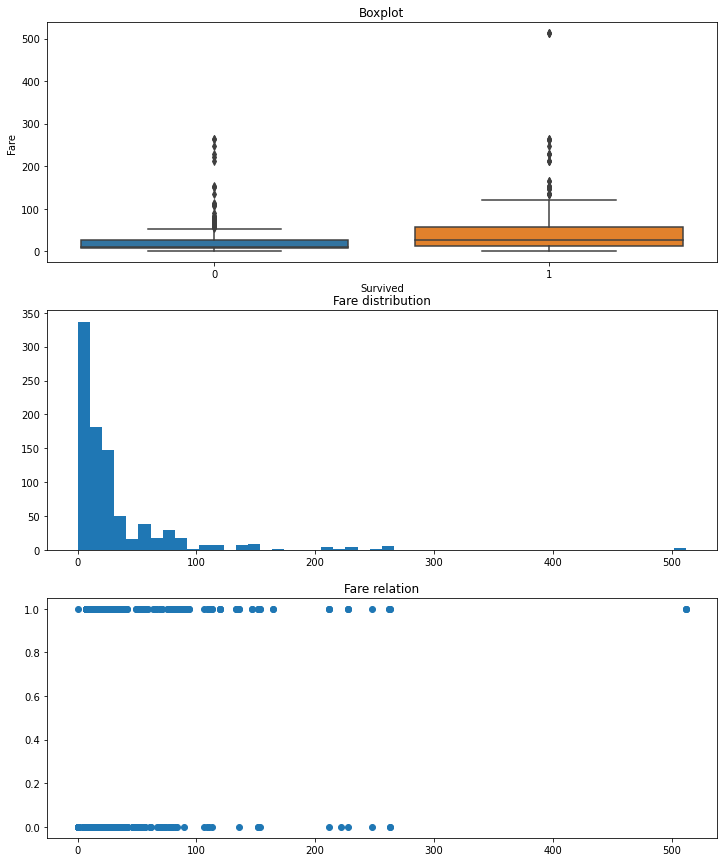

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize = (12, 15))

sns.boxplot(x = dsTrain['Survived'], y = dsTrain['Fare'], ax = ax1)
ax1.set_title('Boxplot')

ax2.hist(dsTrain['Fare'], bins = 50)
ax2.set_title('Fare distribution')

ax3.scatter(dsTrain['Fare'], dsTrain['Survived'])
ax3.set_title('Fare relation')

plt.show()

In [ ]:
dsTrain[['Fare', 'Survived']].groupby(['Survived']).agg(['mean', 'count']).reset_index()

Survived       Fare      
                 mean count
0        0  22.117887   549
1        1  48.395408   342

In [ ]:
# Calculating p-value removing outliers
alpha = 0.05 #Significance level
nSurvived = dsTrain[(dsTrain['Fare'] <= 300) & (dsTrain['Survived'] == 1)]['Fare'].count()
nNoSurvived = dsTrain[(dsTrain['Fare'] <= 300) & (dsTrain['Survived'] == 0)]['Fare'].count()
varSurvived = dsTrain[(dsTrain['Fare'] <= 300) & (dsTrain['Survived'] == 1)]['Fare'].var()
varNoSurvived = dsTrain[(dsTrain['Fare'] <= 300) & (dsTrain['Survived'] == 0)]['Fare'].var()
meanSurvived = dsTrain[(dsTrain['Fare'] <= 300) & (dsTrain['Survived'] == 1)]['Fare'].mean()
meanNoSurvived = dsTrain[(dsTrain['Fare'] <= 300) & (dsTrain['Survived'] == 0)]['Fare'].mean()
diffMean = meanSurvived - meanNoSurvived
se = np.sqrt((varSurvived / nSurvived) + (varNoSurvived / nNoSurvived))

print('Null hypothesis:',  0)
print('Alternative hypothesis:',  diffMean)
print('Standard error:', se)

tTest = (diffMean - 0) / se
print('t-Test:', tTest)

df = np.min([nSurvived - 1, nNoSurvived - 1])
print('Degrees of freedom:', df)

p_value = (1 - stats.t.cdf(tTest, df = df)) * 2 #two-sided test
print('p-value', p_value)

if p_value < alpha:
  print('Conclusion:', 'There is enough evidence to reject null hypothesis, and I can say that there is a difference between survived mean and no survived. So, Fare variable and Survived variable are associated.')
else:
  print('Conclusion:', 'There is not enough evidence to reject null hypothesis, and I can say that there is no a difference between survived mean and no survived. So, Fare variable and Survived variable are not associated.')

# Calculating confidence interval at 95% of confidence
tTest = stats.t.ppf(1 - alpha / 2, df = df)
print('t-Test at 95%', tTest)

ci = (diffMean - tTest*se, diffMean + tTest*se)
print('Confidence interval at 95% of confidence:', ci)

del alpha, nSurvived, nNoSurvived, varSurvived, varNoSurvived, diffMean, se, tTest, df, p_value, ci

Null hypothesis: 0
Alternative hypothesis: 22.171911934813114
Standard error: 3.0509987867272352
t-Test: 7.267099558107862
Degrees of freedom: 338
p-value 2.561728607020086e-12
Conclusion: There is enough evidence to reject null hypothesis, and I can say that there is a difference between survived mean and no survived. So, Fare variable and Survived variable are associated.
t-Test at 95% 1.9670073106670767
Confidence interval at 95% of confidence: (16.17057501648426, 28.173248853141967)


Evaluating whether there is an association between SibSp - Parch and Survived variable using **testing for independence in two-way tables**.

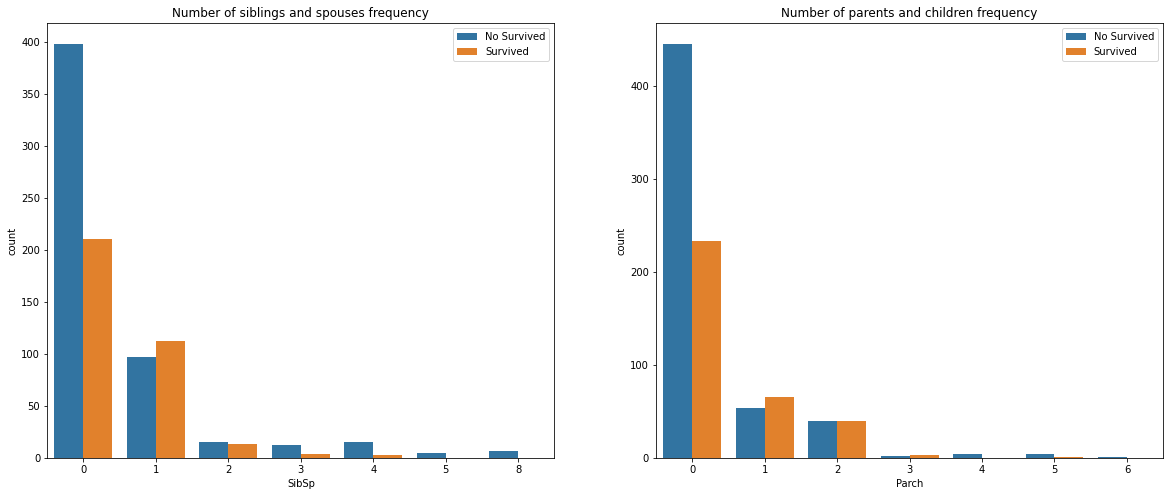

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 8))

sns.countplot(dsTrain['SibSp'], hue = dsTrain['Survived'], ax = ax1)
ax1.set_title('Number of siblings and spouses frequency')
ax1.legend(['No Survived', 'Survived'], loc = 'upper right')

sns.countplot(dsTrain['Parch'], hue = dsTrain['Survived'], ax = ax2)
ax2.set_title('Number of parents and children frequency')
ax2.legend(['No Survived', 'Survived'], loc = 'upper right')

plt.show()

In [ ]:
# Create a new variable FamilySize to make easier the analysis, and SibSp and Parch are very similar.
dsTrain['FamilySize'] = dsTrain['SibSp'] + dsTrain['Parch']
dsTrainPivot =  dsTrain[['PassengerId', 'FamilySize', 'Survived']].groupby(['FamilySize', 'Survived']).count().reset_index()
dsTrainPivot.rename(columns = { 'PassengerId': 'Count' }, inplace = True)
dsTrainPivot = dsTrainPivot.pivot(index = 'Survived', columns = 'FamilySize', values = 'Count')
dsTrainPivot.fillna(0, inplace = True)
dsTrainPivot

FamilySize,0,1,2,3,4,5,6,7,10
Survived,,,,,,,,,
0,374.0,72.0,43.0,8.0,12.0,19.0,8.0,6.0,7.0
1,163.0,89.0,59.0,21.0,3.0,3.0,4.0,0.0,0.0


In [ ]:
alpha = 0.05
chiSquareTest = 0
for r in range(dsTrainPivot.values.shape[0]):
  for c in range(dsTrainPivot.values.shape[1]):
    expectedCount = dsTrainPivot.values[r, :].sum() * dsTrainPivot.values[:, c].sum() / dsTrainPivot.values.sum()
    chiSquareTest = chiSquareTest + ((dsTrainPivot.values[r, c] - expectedCount)**2) / expectedCount
print('Chi-square test:', chiSquareTest)

df = (dsTrainPivot.shape[0] - 1) * (dsTrainPivot.shape[1] - 1)
print('Degrees of freedom', df)

p_value = 1 - stats.chi2.cdf(chiSquareTest, df = df)
print('p-value:', p_value)

if p_value < alpha:
  print('Conclusion:', 'There is enough evidence to reject null hypothesis, and to say that variable Survived and variable FamilySize are associated.')
else:
  print('Conclusion:', 'There is not enough evidence to reject null hypothesis, and to say that variable Survived and variable FamilySize are not associated.')

del dsTrainPivot

Chi-square test: 80.67231343783078
Degrees of freedom 8
p-value: 3.574918139293004e-14
Conclusion: There is enough evidence to reject null hypothesis, and to say that variable Survived and variable FamilySize are associated.


##### Observations:
* **Age**
 * Its distribution is nearly normal.
 * Most people are age from 20 to 40 years old.
 * Range age is from 0 to 80, and thanks that age distribution is nearly normal there is similar amount of observations for both sides: young and old people.
 * Most old people are outliers, in other words, people age more then 70 years old are not common.
 * Using inferential statistical analysis, I can say that young people have more probabilities to survive. Additionally, based on our sample of 714 people and with 95% of confidence, I estimate that age of people who survived are between 4.478 and 0.086 less than age of people who did not survive.
* **Fare**
 * Its distribution is right skewed, where most people paid less than 50.
 * There are many outliers.
 * Using inferential statistical analysis, I can say that people who pay more have more probabilities to survive. Additionally, based on our sample of 891 people and with 95% of confidence, I estimate that fare of people who survived are between 16.17 and 28.17 higher than fare of people who did not survive.
* **SibSp and Parch**
 * Most people who traveled alone did not survive.
 * Using inferential statistical analysis, there is an association between variable Survived and variable FamilySize (SibSp and Parch).

#### 5.1.2. Exploring categorical variables

In [ ]:
dsTrain['Pclass'] = dsTrain['Pclass'].astype('category')

In [ ]:
dsTrain[['Pclass', 'Name', 'Sex' ,'Ticket', 'Cabin', 'Embarked']].describe(include='all')

,Pclass,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,891,204,889
unique,3,891,2,681,147,3
top,3,"Hirvonen, Miss. Hildur E",male,347082,G6,S
freq,491,1,577,7,4,644


Evaluating whether there is an association between Pclass and Survived variable using **testing for independence in two-way tables**.

In [ ]:
dsTrainPivot = dsTrain[['PassengerId', 'Pclass', 'Survived']].groupby(['Survived', 'Pclass'], as_index = False).count()
dsTrainPivot.rename(columns = { 'PassengerId': 'Count' }, inplace = True)
dsTrainPivot = dsTrainPivot.pivot(index = 'Survived', columns = 'Pclass', values = 'Count')
dsTrainPivot

Pclass,1,2,3
Survived,,,
0,80,97,372
1,136,87,119


In [ ]:
alpha = 0.05
chiSquareTest = 0
for r in range(dsTrainPivot.values.shape[0]):
  for c in range(dsTrainPivot.values.shape[1]):
    expectedCount = dsTrainPivot.values[r, :].sum() * dsTrainPivot.values[:, c].sum() / dsTrainPivot.values.sum()
    chiSquareTest = chiSquareTest + ((dsTrainPivot.values[r, c] - expectedCount)**2) / expectedCount
print('Chi-square test:', chiSquareTest)

df = (dsTrainPivot.shape[0] - 1) * (dsTrainPivot.shape[1] - 1)
print('Degrees of freedom', df)

p_value = 1 - stats.chi2.cdf(chiSquareTest, df = df)
print('P-value:', p_value)

if p_value < alpha:
  print('Conclusion:', 'There is enough evidence to reject null hypothesis, and to say that variable survived and variable Pclass are associated.')
else:
  print('Conclusion:', 'There is not enough evidence to reject null hypothesis, and to say that variable survived and variable Pclass are not associated.')

#chi2, p_value = scipy.stats.chi2_contingency(dsTrainPClass.values)[0:2]
del dsTrainPivot

Chi-square test: 102.88898875696056
Degrees of freedom 2
P-value: 0.0
Conclusion: There is enough evidence to reject null hypothesis, and to say that variable survived and variable Pclass are associated.


Evaluating whether there is an association between Sex and Survived variable using **testing for independence in two-way tables**.

In [ ]:
dsTrainPivot = dsTrain[['PassengerId', 'Sex', 'Survived']].groupby(['Survived', 'Sex'], as_index = False).count()
dsTrainPivot.rename(columns = { 'PassengerId': 'Count' }, inplace = True)
dsTrainPivot = dsTrainPivot.pivot(index = 'Survived', columns = 'Sex', values = 'Count')
dsTrainPivot

Sex,female,male
Survived,,
0,81,468
1,233,109


In [ ]:
alpha = 0.05
chiSquareTest = 0
for r in range(dsTrainPivot.values.shape[0]):
  for c in range(dsTrainPivot.values.shape[1]):
    expectedCount = dsTrainPivot.values[r, :].sum() * dsTrainPivot.values[:, c].sum() / dsTrainPivot.values.sum()
    chiSquareTest = chiSquareTest + ((dsTrainPivot.values[r, c] - expectedCount)**2) / expectedCount
print('Chi-square test:', chiSquareTest)

df = (dsTrainPivot.shape[0] - 1) * (dsTrainPivot.shape[1] - 1)
print('Degrees of freedom', df)

p_value = 1 - stats.chi2.cdf(chiSquareTest, df = df)
print('P-value:', p_value)

if p_value < alpha:
  print('Conclusion:', 'There is enough evidence to reject null hypothesis, and to say that variable survived and variable Sex are associated.')
else:
  print('Conclusion:', 'There is not enough evidence to reject null hypothesis, and to say that variable survived and variable Sex are not associated.')

#chi2, p_value = scipy.stats.chi2_contingency(dsTrainSex.values)[0:2]
del dsTrainPivot

Chi-square test: 263.05057407065567
Degrees of freedom 1
P-value: 0.0
Conclusion: There is enough evidence to reject null hypothesis, and to say that variable survived and variable Sex are associated.


Evaluating whether there is an association between Embarked and Survived variable using **testing for independence in two-way tables**.

In [ ]:
dsTrainPivot = dsTrain[['PassengerId', 'Embarked', 'Survived']].groupby(['Survived', 'Embarked'], as_index = False).count()
dsTrainPivot.rename(columns = { 'PassengerId': 'Count' }, inplace = True)
dsTrainPivot = dsTrainPivot.pivot(index = 'Survived', columns = 'Embarked', values = 'Count')
dsTrainPivot

Embarked,C,Q,S
Survived,,,
0,75,47,427
1,93,30,217


In [ ]:
alpha = 0.05
chiSquareTest = 0
for r in range(dsTrainPivot.values.shape[0]):
  for c in range(dsTrainPivot.values.shape[1]):
    expectedCount = dsTrainPivot.values[r, :].sum() * dsTrainPivot.values[:, c].sum() / dsTrainPivot.values.sum()
    chiSquareTest = chiSquareTest + ((dsTrainPivot.values[r, c] - expectedCount)**2) / expectedCount
print('Chi-square test:', chiSquareTest)

df = (dsTrainPivot.shape[0] - 1) * (dsTrainPivot.shape[1] - 1)
print('Degrees of freedom', df)

p_value = 1 - stats.chi2.cdf(chiSquareTest, df = df)
print('P-value:', p_value)

if p_value < alpha:
  print('Conclusion:', 'There is enough evidence to reject null hypothesis, and to say that variable survived and variable Embarked are associated.')
else:
  print('Conclusion:', 'There is not enough evidence to reject null hypothesis, and to say that variable survived and variable Embarked are not associated.')

#chi2, p_value = scipy.stats.chi2_contingency(dsTrainPivot.values)[0:2]
del dsTrainPivot

Chi-square test: 26.48914983923762
Degrees of freedom 2
P-value: 1.769922284067249e-06
Conclusion: There is enough evidence to reject null hypothesis, and to say that variable survived and variable Embarked are associated.


###5.2. Exploratory data analysis for testing data

In [ ]:
dsTest.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


The testing dataset has 418 observations.

This data is equivalent to 50% of traing data, in real cases, testing data is usually 20% or less of training data.

In [ ]:
dsTest.shape

(418, 11)

This dataset has many null observations, fortunately most variables are complete.

In [ ]:
dsTest.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


#### 5.2.1. Exploring numerical variables

In [ ]:
dsTest[['PassengerId','Age', 'SibSp', 'Parch', 'Fare']].describe()

,PassengerId,Age,SibSp,Parch,Fare
count,418.000000,332.000000,418.000000,418.000000,417.000000
mean,1100.500000,30.272590,0.447368,0.392344,35.627188
std,120.810458,14.181209,0.896760,0.981429,55.907576
min,892.000000,0.170000,0.000000,0.000000,0.000000
25%,996.250000,21.000000,0.000000,0.000000,7.895800
50%,1100.500000,27.000000,0.000000,0.000000,14.454200
75%,1204.750000,39.000000,1.000000,0.000000,31.500000
max,1309.000000,76.000000,8.000000,9.000000,512.329200


/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


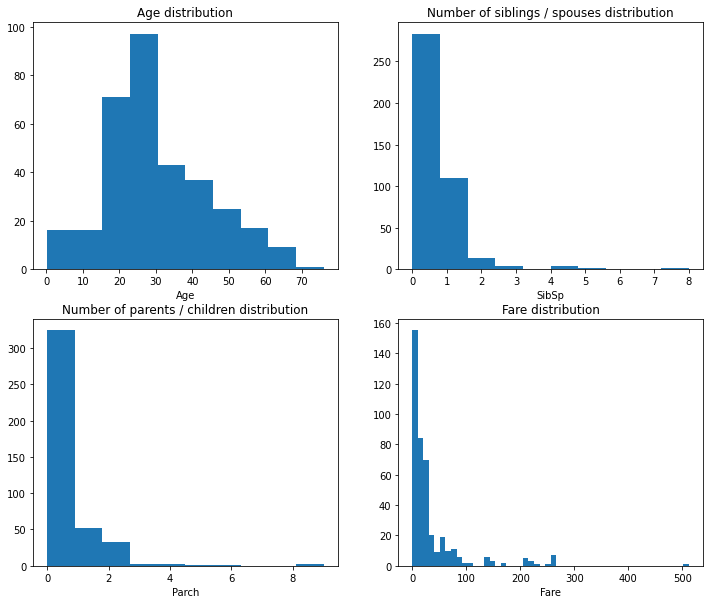

In [ ]:
# fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, sharey=True, figsize=(12, 10))
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))
ax1.hist(dsTest['Age'])
ax1.set_xlabel('Age')
ax1.set_title('Age distribution')

ax2.hist(dsTest['SibSp'])
ax2.set_xlabel('SibSp')
ax2.set_title('Number of siblings / spouses distribution')

ax3.hist(dsTest['Parch'])
ax3.set_xlabel('Parch')
ax3.set_title('Number of parents / children distribution')

ax4.hist(dsTest['Fare'], bins = 50)
ax4.set_xlabel('Fare')
ax4.set_title('Fare distribution')

plt.show()

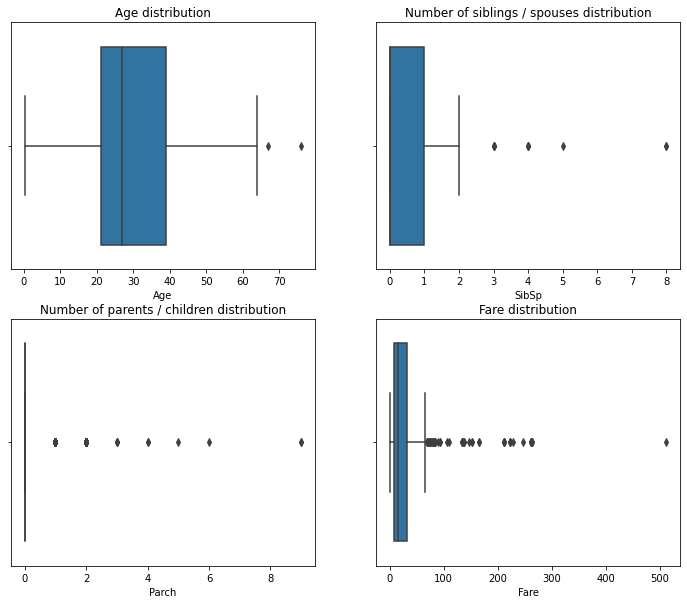

In [ ]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))
sns.boxplot(dsTest['Age'], ax = ax1)
ax1.set_xlabel('Age')
ax1.set_title('Age distribution')

sns.boxplot(dsTest['SibSp'], ax = ax2)
ax2.set_xlabel('SibSp')
ax2.set_title('Number of siblings / spouses distribution')

sns.boxplot(dsTest['Parch'], ax = ax3)
ax3.set_xlabel('Parch')
ax3.set_title('Number of parents / children distribution')

sns.boxplot(dsTest['Fare'], ax = ax4)
ax4.set_xlabel('Fare')
ax4.set_title('Fare distribution')

plt.show()

##### Observations:
* Only age distribution is nearly normal.

#### 5.2.2. Exploring categorical variables

In [ ]:
dsTest['Pclass'].value_counts()

3    218
1    107
2     93
Name: Pclass, dtype: int64

In [ ]:
dsTest['Sex'].value_counts()

male      266
female    152
Name: Sex, dtype: int64

In [ ]:
dsTest['Embarked'].value_counts()

S    270
C    102
Q     46
Name: Embarked, dtype: int64

## 6. Data preparation:

### 6.1. Training data:

##### Numerical

* Drop PassengerId, because its value is only an incremental number.
* Transform Age to categorical.
* Transform SibSp to categorical in order to identify who is married.
* Transform Parch to categorical in order to identify who is parent.


##### Categorical

* Transform Name to categorical.
* Drop Ticket.
* Drop Cabin.

In [ ]:
dsTrain.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   PassengerId  891 non-null    int64   
 1   Survived     891 non-null    int64   
 2   Pclass       891 non-null    category
 3   Name         891 non-null    object  
 4   Sex          891 non-null    object  
 5   Age          714 non-null    float64 
 6   SibSp        891 non-null    int64   
 7   Parch        891 non-null    int64   
 8   Ticket       891 non-null    object  
 9   Fare         891 non-null    float64 
 10  Cabin        204 non-null    object  
 11  Embarked     889 non-null    object  
 12  FamilySize   891 non-null    int64   
dtypes: category(1), float64(2), int64(5), object(5)
memory usage: 84.6+ KB


##### Create new variables
* **Title**: I will create this feature based on the name of each passenger in order to get calculate missing values in age. Name feature does not have missing values.
* **FamilySize**: this feature will store amount of family.
* **AgeClass**: this feature categorizes age by ranges in order to help the model to work with ages.

In [ ]:
dsTrain['Title'] = dsTrain['Name'].map(lambda x: re.findall('([A-Za-z]+)\.', x)[0])
dsTrain['FamilySize'] = dsTrain['SibSp'] + dsTrain['Parch']

##### Treat missing values
* **Age**: I will use title to fill age.
* **Embarked**: I will use "C" to fill missing value. There is no a particular reason to select this value. "C" is the most common value.

In [ ]:
dsTrain['Age'] = dsTrain['Age'].fillna(dsTrain.groupby('Title')['Age'].transform('median'))
dsTrain['Age'].isna().sum()

0

In [ ]:
dsTrain['Embarked'] = dsTrain['Embarked'].fillna('C')
dsTrain['Embarked'].isna().sum()

0

##### Remove outliers

In [ ]:
dsTrain = dsTrain[dsTrain['Fare'] <= 300]

##### Categorize age feature.

In [ ]:
def setClassAge(x):
  '''
    Objective: categorize age by range.
    Inputs:
      x (number): age
  '''
  if x <= 15:
    return 0 # Kid
  elif x > 15 and x <= 30:
    return 1 # Young
  elif x > 30 and x <= 50:
    return 2 # Adult
  else:
    return 3 # Mayor
dsTrain['Age'] = dsTrain['Age'].astype('int')
dsTrain['AgeClass'] = dsTrain['Age'].apply(setClassAge)

##### Categorize fare feature

In [ ]:
def setClassFare(x):
  '''
    Objective: categorize fare by range
    Inputs:
      x (number): fare
  '''
  if x <= 50:
    return 0
  elif x > 50 and x <= 100:
    return 1
  elif x > 100 and x <= 150:
    return 2
  elif x > 150 and x <= 200:
    return 3
  elif x > 200 and x <= 250:
    return 4
  elif x > 250 and x <= 300:
    return 5
  elif x > 300 and x <= 350:
    return 6
  elif x > 400 and x <= 450:
    return 7
  elif x > 450 and x <= 500:
    return 8
  else:
    return 9
dsTrain['FareClass'] = dsTrain['Fare'].apply(setClassFare)

##### Set correct Dtype

In [ ]:
dsTrain['FamilySize'] = dsTrain['FamilySize'].astype('category')
dsTrain['Survived'] = dsTrain['Survived'].astype('category')
dsTrain['Pclass'] = dsTrain['Pclass'].astype('category')
dsTrain['AgeClass'] = dsTrain['AgeClass'].astype('category')
dsTrain['FareClass'] = dsTrain['FareClass'].astype('category')

In [ ]:
dsTrain.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize,Title,AgeClass,FareClass
0,1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.2500,NaN,S,1,Mr,1,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38,1,0,PC 17599,71.2833,C85,C,1,Mrs,2,1
2,3,1,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.9250,NaN,S,0,Miss,1,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1000,C123,S,1,Mrs,2,1
4,5,0,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.0500,NaN,S,0,Mr,2,0


##### Remove features

In [ ]:
dsTrain.drop(['PassengerId', 'Name', 'Age', 'SibSp', 'Parch', 'Ticket', 'Cabin', 'Title', 'Fare'], axis = 1, inplace = True)

In [ ]:
dsTrain.head()

,Survived,Pclass,Sex,Embarked,FamilySize,AgeClass,FareClass
0,0,3,male,S,1,1,0
1,1,1,female,C,1,2,1
2,1,3,female,S,0,1,0
3,1,1,female,S,1,2,1
4,0,3,male,S,0,2,0


##### Transform features

In [ ]:
x_train = dsTrain.drop('Survived', axis = 1)
y_train = dsTrain['Survived']

In [ ]:
x_train = pd.get_dummies(x_train, drop_first = True)
x_train.head()

,Pclass_2,Pclass_3,Sex_male,Embarked_Q,Embarked_S,FamilySize_1,FamilySize_2,FamilySize_3,FamilySize_4,FamilySize_5,FamilySize_6,FamilySize_7,FamilySize_10,AgeClass_1,AgeClass_2,AgeClass_3,FareClass_1,FareClass_2,FareClass_3,FareClass_4,FareClass_5
0,0,1,1,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0
2,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
3,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0
4,0,1,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0


In [ ]:
x_train.shape

(888, 21)

### 6.2. Testing data

In [ ]:
dsTest.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


##### Create new variables

In [ ]:
dsTest['Title'] = dsTest['Name'].map(lambda x: re.findall('([A-Za-z]+)\.', x)[0])
dsTest['FamilySize'] = dsTest['SibSp'] + dsTest['Parch']

##### Remove outliers

In [ ]:
dsTest = dsTest[dsTest['Fare'] <= 300]

##### Treat missing values

In [ ]:
dsTest['Age'] = dsTest['Age'].fillna(dsTest.groupby('Title')['Age'].transform('median'))
dsTest['Age'].isna().sum()

1

In [ ]:
dsTest['Age'] = dsTest['Age'].fillna(dsTest['Age'].median())
dsTest['Age'].isna().sum()

0

In [ ]:
dsTest['Embarked'] = dsTest['Embarked'].fillna('C')
dsTest['Embarked'].isna().sum()

0

##### Categorize age feature

In [ ]:
dsTest['Age'] = dsTest['Age'].astype('int')
dsTest['AgeClass'] = dsTest['Age'].apply(setClassAge)

##### Categorize fare feature

In [ ]:
dsTest['FareClass'] = dsTest['Fare'].apply(setClassFare)

##### Set correct Dtype

In [ ]:
dsTest['FamilySize'] = dsTest['FamilySize'].astype('category')
dsTest['Pclass'] = dsTest['Pclass'].astype('category')
dsTest['AgeClass'] = dsTest['AgeClass'].astype('category')
dsTest['FareClass'] = dsTest['FareClass'].astype('category')

In [ ]:
dsTest.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,FamilySize,AgeClass,FareClass
0,892,3,"Kelly, Mr. James",male,34,0,0,330911,7.8292,NaN,Q,Mr,0,2,0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47,1,0,363272,7.0000,NaN,S,Mrs,1,2,0
2,894,2,"Myles, Mr. Thomas Francis",male,62,0,0,240276,9.6875,NaN,Q,Mr,0,3,0
3,895,3,"Wirz, Mr. Albert",male,27,0,0,315154,8.6625,NaN,S,Mr,0,1,0
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22,1,1,3101298,12.2875,NaN,S,Mrs,2,1,0


##### Remove features
I will keep PassengerId, because I need it to create the file submission.

In [ ]:
dsTest.drop(['Name', 'Age', 'SibSp', 'Parch', 'Ticket', 'Cabin', 'Title', 'Fare'], axis = 1, inplace = True)

In [ ]:
dsTest.head()

,PassengerId,Pclass,Sex,Embarked,FamilySize,AgeClass,FareClass
0,892,3,male,Q,0,2,0
1,893,3,female,S,1,2,0
2,894,2,male,Q,0,3,0
3,895,3,male,S,0,1,0
4,896,3,female,S,2,1,0


##### Transform features

In [ ]:
# PassengerId
x_test = pd.get_dummies(dsTest[['Pclass', 'Sex', 'Embarked', 'FamilySize', 'AgeClass', 'FareClass']], drop_first = True)
x_test.head()

,Pclass_2,Pclass_3,Sex_male,Embarked_Q,Embarked_S,FamilySize_1,FamilySize_2,FamilySize_3,FamilySize_4,FamilySize_5,FamilySize_6,FamilySize_7,FamilySize_10,AgeClass_1,AgeClass_2,AgeClass_3,FareClass_1,FareClass_2,FareClass_3,FareClass_4,FareClass_5
0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
1,0,1,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
3,0,1,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
4,0,1,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0


In [ ]:
x_test = pd.concat([dsTest['PassengerId'], x_test], axis = 1)
print(x_test.shape)
x_test.head()

(416, 22)


,PassengerId,Pclass_2,Pclass_3,Sex_male,Embarked_Q,Embarked_S,FamilySize_1,FamilySize_2,FamilySize_3,FamilySize_4,FamilySize_5,FamilySize_6,FamilySize_7,FamilySize_10,AgeClass_1,AgeClass_2,AgeClass_3,FareClass_1,FareClass_2,FareClass_3,FareClass_4,FareClass_5
0,892,0,1,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
1,893,0,1,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2,894,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
3,895,0,1,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
4,896,0,1,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0


## 7. Modeling
In this stage, I will create the models. I will only use K nearest neighbor and logistic regression.

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import validation_curve

from sklearn import metrics

##### Split data keeping the distribution for train and val dataset

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Val set:', X_val.shape,  y_val.shape)

Train set: (710, 21) (710,)
Val set: (178, 21) (178,)


In [ ]:
X_test = x_test.drop('PassengerId', axis = 1).values
print('Test set:', X_test.shape)

Test set: (416, 21)


### 7.1. K nearest neighbor (KNN)

In [ ]:
k = 15
mean_acc = np.zeros((k - 1))
std_acc = np.zeros((k - 1))
confusion_matrices = []
f1s = []

for n in range(1, k):
    
    #Train Model and Predict  
    knn = KNeighborsClassifier(n_neighbors = n).fit(X_train, y_train)
    yhat = knn.predict(X_val)

    mean_acc[n-1] = metrics.accuracy_score(y_val, yhat)
    std_acc[n-1] = np.std(yhat == y_val) / np.sqrt(yhat.shape[0])
    confusion_matrices.append(metrics.confusion_matrix(y_val, yhat, labels = [0, 1]))
    f1s.append(metrics.f1_score(y_val, yhat))

mean_acc

array([0.74719101, 0.74719101, 0.82022472, 0.8258427 , 0.82022472,
       0.83146067, 0.8258427 , 0.82022472, 0.81460674, 0.82022472,
       0.7752809 , 0.80898876, 0.79775281, 0.80898876])

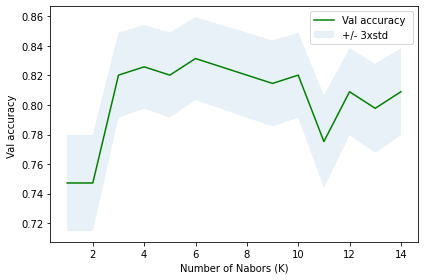

In [ ]:
plt.plot(range(1, k), mean_acc, 'g')
plt.fill_between(range(1, k), mean_acc - 1 * std_acc, mean_acc + 1 * std_acc, alpha=0.10)
plt.legend(('Val accuracy ', '+/- 3xstd'))
plt.ylabel('Val accuracy ')
plt.xlabel('Number of Nabors (K)')
plt.tight_layout()
plt.show()

Get Optimizing metrics

In [ ]:
# what percentage of correct predictions were made?
print("The best accuracy was ", mean_acc.max(), "with k=", mean_acc.argmax() + 1) 

The best accuracy was  0.8314606741573034 with k= 6


In [ ]:
print('F1-score:', f1s[mean_acc.argmax()])

F1-score: 0.7413793103448276


### 7.2. Logistic regression

In [ ]:
irs = np.linspace(0.01, 1, num = 10)
mean_acc = np.zeros(len(irs))
confusion_matricesLR = []
f1s = []
       
for i in range(len(irs)):
  LR = LogisticRegression(C = irs[i], solver = 'liblinear').fit(X_train, y_train)
  yhat = LR.predict(X_val)
  yhat_prob = LR.predict_proba(X_val)
  mean_acc[i] = metrics.accuracy_score(y_val, yhat)
  #confusion_matricesLR.append(metrics.confusion_matrix(y_val, yhat, labels = [0, 1]))
  f1s.append(metrics.f1_score(y_val, yhat))

mean_acc

array([0.75842697, 0.8258427 , 0.80337079, 0.80337079, 0.82022472,
       0.82022472, 0.82022472, 0.82022472, 0.8258427 , 0.8258427 ])

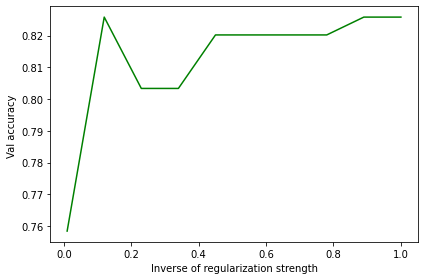

In [ ]:
plt.plot(irs, mean_acc, 'g')
plt.ylabel('Val accuracy ')
plt.xlabel('Inverse of regularization strength')
plt.tight_layout()
plt.show()

Get Optimizing metrics

In [ ]:
print("The best accuracy was ", mean_acc.max(), "with C = ", irs[mean_acc.argmax()])

The best accuracy was  0.8258426966292135 with C =  0.12


In [ ]:
print('F1-score:', f1s[mean_acc.argmax()])

F1-score: 0.743801652892562


### 7.3. Predict using test data
To predict new values I will use the best model (best metrics).

In [ ]:
x_test

,PassengerId,Pclass_2,Pclass_3,Sex_male,Embarked_Q,Embarked_S,FamilySize_1,FamilySize_2,FamilySize_3,FamilySize_4,FamilySize_5,FamilySize_6,FamilySize_7,FamilySize_10,AgeClass_1,AgeClass_2,AgeClass_3,FareClass_1,FareClass_2,FareClass_3,FareClass_4,FareClass_5
0,892,0,1,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
1,893,0,1,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2,894,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
3,895,0,1,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
4,896,0,1,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,1305,0,1,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
414,1306,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0
415,1307,0,1,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
416,1308,0,1,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0


In [ ]:
knn = KNeighborsClassifier(n_neighbors = 6).fit(X_train, y_train)
y_predTest = knn.predict(X_test)
y_predTest

array([0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0,
       1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0,
       1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0,
       0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1,
       0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0,
       0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,

In [ ]:
dsSubmission = pd.DataFrame({'PassengerId': x_test['PassengerId'].values, 'Survived': y_predTest})
dsSubmission.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0


In [ ]:
dsSubmission.to_csv('titanic_submission.csv', index=False)

## 8. Conclusion
I built a model that can predict whether a person can survive or not. People with high probability to survive will pay less, and the model can help to filter those people.